In [1]:
from rdkit import Chem
import sys
import os
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from collections import Counter
import mols2grid
from tdc.single_pred import ADME
from Filtering_functions import filter_molecules
import glob

In [2]:
# Get the current working directory
current_dir = os.getcwd()
print(current_dir)
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(parent_dir)
# Add the parent directory to sys.path
sys.path.append(parent_dir)

/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/Targetdiff
/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model


Set the default image size

In [3]:
uru.rd_set_image_size(300,300)

### Reading the data from Targetdiff

See if they are valid or not

In [4]:
smi_list = []
with open('/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/Targetdiff/combined_smiles_target_diff.txt') as f:
    for smi in f:
        smi_list.append(smi.strip())
standardized_smiles_list = []
for smi in smi_list:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        standardized_smiles_list.append(Chem.MolToSmiles(mol))

print(len(smi_list))
len(standardized_smiles_list)

989


989

Convert SMILES and name of them to a dataframe

In [5]:
df = pd.DataFrame(standardized_smiles_list, columns=['SMILES'])
df

,SMILES
0,CN1C=NC2=C(C1)OC(C1=CC(O)C=CC1O)C2CCC(O)C(=O)O
1,CC1CC(O)C(O)C(C2(C=C3NCC(F)O3)NC3=CC(=O)N(N)NC...
2,O=CC(CC1CCNC1=O)c1cc(N2CC(O)OCC2=O)cc(C(F)(F)F)c1
3,CNC(C(=O)O)C1C=CC(C(CC(F)F)CC(C)(O)O)C=C1F
4,CCN(OCCN(CO)CCNC(=O)c1cccc(F)c1)C1C=CC=C(O)C(N...
...,...
984,COC1C(O)CC2CC1C1NC(O)CC(O)C1CC2O
985,COCC(O)C(O)C(O)C(CO)C(N)=O
986,CC1CC(CN)N2C1C1OC(C(=O)O)C(O)C(O)C12
987,CC1(CCC(O)C(=O)O)COC(O)COC1=O


Add an RDKit molecule to the dataframe

In [6]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Strip salts from the molecule

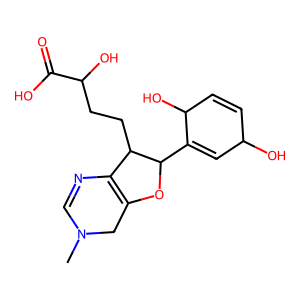

In [7]:
df.mol = df.mol.apply(uru.get_largest_fragment)
df.mol[0]

In [8]:
mols2grid.display(df)

MolGridWidget()

Instantiate a RingSystemFinder object and find ring systems for the molecules in df

In [9]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)
df.ring_sytems

0                       [C1=NC2=C(CN1)OCC2, C1=CCC=CC1]
1      [C1CCCCC1, O=C1C=C2NCC(=O)C2C(=O)NN1, C=C1NCCO1]
2                     [O=C1CCCN1, c1ccccc1, O=C1COCCN1]
3                                          [C1=CCC=CC1]
4                     [c1ccccc1, C1=CC=CCC=C1, C1CCNC1]
                             ...                       
984                            [C1CNC2C(C1)CCC1CCCC2C1]
985                                                  []
986                               [C1COC2C(C1)N1CCCC21]
987                                       [O=C1CCOCCO1]
988                                       [O=C1NC=CCN1]
Name: ring_sytems, Length: 989, dtype: object

In [10]:
df.ring_sytems.values

array([list(['C1=NC2=C(CN1)OCC2', 'C1=CCC=CC1']),
       list(['C1CCCCC1', 'O=C1C=C2NCC(=O)C2C(=O)NN1', 'C=C1NCCO1']),
       list(['O=C1CCCN1', 'c1ccccc1', 'O=C1COCCN1']),
       list(['C1=CCC=CC1']),
       list(['c1ccccc1', 'C1=CC=CCC=C1', 'C1CCNC1']),
       list(['C=C=C1C=CC=CC1', 'O=C1CCCCCN1']),
       list(['C1=NC2NCNC2=NC1', 'C1CCCC1']),
       list(['N=C1CCCCN1', 'C1=CNCCCC1', 'O=C1CCCN1']),
       list(['O=C1CCCCCCN1', 'C1=CC=CCC=C1']), list(['O=C1CCCCC1']),
       list(['O=C1CCC2=C1C=CCC2']), list(['C1=CCCNC=CC1']),
       list(['C1=CC2CCCN3COC(=C23)C1', 'C1=C2NCCC2CC1']),
       list(['N=C1OC2CCCOC2C1=O']), list([]),
       list(['C1CCCCCC1', 'c1ccccc1']), list(['C1=CCCCC1', 'C1CCCCC1']),
       list([]), list(['O=C1CCC2CC=NC(=S)N12', 'C1CCCC1']),
       list(['O=C1CC2=CCC=CC2=NCO1', 'c1ccncc1']),
       list(['O=C1c2ccccc2C2C3=CNCC3CN12']),
       list(['c1ccccc1', 'c1ccc2c(c1)CC1CCN21']),
       list(['c1nc2c([nH]1)=NC1CCOC3CCC=2N13']),
       list(['C1COCO1', 'C1=Nc2n[n

See how many times each ring system occurs

In [11]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"]) ### Convert a dictionary to a DataFrame.
ring_count_df.sort_values("Count",ascending=False,inplace=True)
ring_count_df

,SMILES,Count
6,c1ccccc1,230
1,C1=CCC=CC1,80
13,C1CCCC1,56
9,C1CCNC1,34
8,C1=CC=CCC=C1,34
...,...,...
309,C1=CCC2CCC=CC2=CC1,1
310,C1=CC2CC3C4=NC5=CCNCC5C5CCC6=CCC=C(CCCC3C2C=CC...,1
311,C1CCC2CCC(C1)C2,1
312,c1ccc2c(c1)CCCCOCO2,1


View the ring system frequencies

In [12]:
mols2grid.display(ring_count_df,subset=["img","Count"])

MolGridWidget()

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [13]:
ring_system_lookup = uru.RingSystemLookup.default()
res = df.mol.apply(ring_system_lookup.process_mol)

In [14]:
res

0             [(C1=NC2=C(CN1)OCC2, 0), (C1=CCC=CC1, 87)]
1      [(C1CCCCC1, 77480), (O=C1C=C2NCC(=O)C2C(=O)NN1...
2      [(O=C1CCCN1, 14446), (c1ccccc1, 2260082), (O=C...
3                                     [(C1=CCC=CC1, 87)]
4      [(c1ccccc1, 2260082), (C1=CC=CCC=C1, 8), (C1CC...
                             ...                        
984                        [(C1CNC2C(C1)CCC1CCCC2C1, 0)]
985                                                   []
986                           [(C1COC2C(C1)N1CCCC21, 0)]
987                                   [(O=C1CCOCCO1, 0)]
988                                [(O=C1NC=CCN1, 2660)]
Name: mol, Length: 989, dtype: object

In [15]:
df[['min_ring','min_freq']] = res.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq
0,CN1C=NC2=C(C1)OC(C1=CC(O)C=CC1O)C2CCC(O)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x7d4bd596a0a0>,"[C1=NC2=C(CN1)OCC2, C1=CCC=CC1]",C1=NC2=C(CN1)OCC2,0
1,CC1CC(O)C(O)C(C2(C=C3NCC(F)O3)NC3=CC(=O)N(N)NC...,<rdkit.Chem.rdchem.Mol object at 0x7d4bd599dc40>,"[C1CCCCC1, O=C1C=C2NCC(=O)C2C(=O)NN1, C=C1NCCO1]",O=C1C=C2NCC(=O)C2C(=O)NN1,0
2,O=CC(CC1CCNC1=O)c1cc(N2CC(O)OCC2=O)cc(C(F)(F)F)c1,<rdkit.Chem.rdchem.Mol object at 0x7d4bd599dcb0>,"[O=C1CCCN1, c1ccccc1, O=C1COCCN1]",O=C1COCCN1,594
3,CNC(C(=O)O)C1C=CC(C(CC(F)F)CC(C)(O)O)C=C1F,<rdkit.Chem.rdchem.Mol object at 0x7d4bd599dd20>,[C1=CCC=CC1],C1=CCC=CC1,87
4,CCN(OCCN(CO)CCNC(=O)c1cccc(F)c1)C1C=CC=C(O)C(N...,<rdkit.Chem.rdchem.Mol object at 0x7d4bd599dd90>,"[c1ccccc1, C1=CC=CCC=C1, C1CCNC1]",C1=CC=CCC=C1,8
...,...,...,...,...,...
984,COC1C(O)CC2CC1C1NC(O)CC(O)C1CC2O,<rdkit.Chem.rdchem.Mol object at 0x7d4bd59b8dd0>,[C1CNC2C(C1)CCC1CCCC2C1],C1CNC2C(C1)CCC1CCCC2C1,0
985,COCC(O)C(O)C(O)C(CO)C(N)=O,<rdkit.Chem.rdchem.Mol object at 0x7d4bd59b8e40>,[],,-1
986,CC1CC(CN)N2C1C1OC(C(=O)O)C(O)C(O)C12,<rdkit.Chem.rdchem.Mol object at 0x7d4bd59b8eb0>,[C1COC2C(C1)N1CCCC21],C1COC2C(C1)N1CCCC21,0
987,CC1(CCC(O)C(=O)O)COC(O)COC1=O,<rdkit.Chem.rdchem.Mol object at 0x7d4bd59b8f20>,[O=C1CCOCCO1],O=C1CCOCCO1,0


In [16]:
df_ring_appearance_0 = df[df.min_freq == 0]
df_ring_appearance_0

,SMILES,mol,ring_sytems,min_ring,min_freq
0,CN1C=NC2=C(C1)OC(C1=CC(O)C=CC1O)C2CCC(O)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x7d4bd596a0a0>,"[C1=NC2=C(CN1)OCC2, C1=CCC=CC1]",C1=NC2=C(CN1)OCC2,0
1,CC1CC(O)C(O)C(C2(C=C3NCC(F)O3)NC3=CC(=O)N(N)NC...,<rdkit.Chem.rdchem.Mol object at 0x7d4bd599dc40>,"[C1CCCCC1, O=C1C=C2NCC(=O)C2C(=O)NN1, C=C1NCCO1]",O=C1C=C2NCC(=O)C2C(=O)NN1,0
5,CCNC(=C=C1CC(ON)=CC=C1CN1CCC(O)C(C)C(C)C1=O)C(...,<rdkit.Chem.rdchem.Mol object at 0x7d4bd599de00>,"[C=C=C1C=CC=CC1, O=C1CCCCCN1]",C=C=C1C=CC=CC1,0
6,NCC(C(=O)O)C1(O)C=NC2C(=N1)N(CC(F)(F)F)CN2C1CC...,<rdkit.Chem.rdchem.Mol object at 0x7d4bd599de70>,"[C1=NC2NCNC2=NC1, C1CCCC1]",C1=NC2NCNC2=NC1,0
7,N=C1NC(C(O)C2=C(O)C(CC3(F)CC(CO)NC3=O)CCC(C(=O...,<rdkit.Chem.rdchem.Mol object at 0x7d4bd599dee0>,"[N=C1CCCCN1, C1=CNCCCC1, O=C1CCCN1]",C1=CNCCCC1,0
...,...,...,...,...,...
981,O=C(O)C1OC2C(CO)C3CC(O)CCOC3C(O)C12,<rdkit.Chem.rdchem.Mol object at 0x7d4bd59b8c80>,[C1CCC2CC3OCC3CC2OC1],C1CCC2CC3OCC3CC2OC1,0
983,C=CN(CC)C(=C=C1C=CC(OP(=O)(O)OC2C(O)C3CC2(O)C2...,<rdkit.Chem.rdchem.Mol object at 0x7d4bd59b8d60>,"[C=C=C1C=CC=CC1, C1=NCC2=NC3C4CCC(C4)C3CN12]",C=C=C1C=CC=CC1,0
984,COC1C(O)CC2CC1C1NC(O)CC(O)C1CC2O,<rdkit.Chem.rdchem.Mol object at 0x7d4bd59b8dd0>,[C1CNC2C(C1)CCC1CCCC2C1],C1CNC2C(C1)CCC1CCCC2C1,0
986,CC1CC(CN)N2C1C1OC(C(=O)O)C(O)C(O)C12,<rdkit.Chem.rdchem.Mol object at 0x7d4bd59b8eb0>,[C1COC2C(C1)N1CCCC21],C1COC2C(C1)N1CCCC21,0


In [17]:
df_ring_appearance_0['SMILES'].to_csv('targetdiff_ring_appearance_0.smi',index=False,header=False)

In [18]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

### Check how many molecules are unique the ring frequency of them

How many molecules are unique using inChI?

In [19]:
df['inchi'] = df.mol.apply(Chem.MolToInchi)
df = df.drop_duplicates("inchi", keep="first", ignore_index=True)
df

[20:50:48] WARNING: Omitted undefined stereo

[20:50:48] WARNING: Omitted undefined stereo

[20:50:48] WARNING: Omitted undefined stereo

[20:50:48] WARNING: Omitted undefined stereo

[20:50:48] WARNING: Omitted undefined stereo

[20:50:48] WARNING: Omitted undefined stereo

[20:50:48] WARNING: Omitted undefined stereo

[20:50:48] WARNING: Omitted undefined stereo

[20:50:48] WARNING: Omitted undefined stereo

[20:50:48] WARNING: Omitted undefined stereo

[20:50:48] WARNING: Omitted undefined stereo

[20:50:48] WARNING: Omitted undefined stereo

[20:50:48] WARNING: Omitted undefined stereo

[20:50:48] WARNING: Omitted undefined stereo

[20:50:48] WARNING: Omitted undefined stereo

[20:50:48] WARNING: Omitted undefined stereo

[20:50:48] WARNING: Omitted undefined stereo

[20:50:48] WARNING: Omitted undefined stereo

[20:50:48] WARNING: Omitted undefined stereo

[20:50:48] WARNING: Omitted undefined stereo

[20:50:48] WARNING: Omitted undefined stereo

[20:50:48] WARNING: Omitted undefi

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,CN1C=NC2=C(C1)OC(C1=CC(O)C=CC1O)C2CCC(O)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x7d4bd596a0a0>,"[C1=NC2=C(CN1)OCC2, C1=CCC=CC1]",C1=NC2=C(CN1)OCC2,0,InChI=1S/C17H22N2O6/c1-19-7-14-15(18-8-19)10(3...
1,CC1CC(O)C(O)C(C2(C=C3NCC(F)O3)NC3=CC(=O)N(N)NC...,<rdkit.Chem.rdchem.Mol object at 0x7d4bd599dc40>,"[C1CCCCC1, O=C1C=C2NCC(=O)C2C(=O)NN1, C=C1NCCO1]",O=C1C=C2NCC(=O)C2C(=O)NN1,0,InChI=1S/C19H26FN5O6/c1-7-3-10(26)16(28)15(8(7...
2,O=CC(CC1CCNC1=O)c1cc(N2CC(O)OCC2=O)cc(C(F)(F)F)c1,<rdkit.Chem.rdchem.Mol object at 0x7d4bd599dcb0>,"[O=C1CCCN1, c1ccccc1, O=C1COCCN1]",O=C1COCCN1,594,"InChI=1S/C18H19F3N2O5/c19-18(20,21)13-4-11(12(..."
3,CNC(C(=O)O)C1C=CC(C(CC(F)F)CC(C)(O)O)C=C1F,<rdkit.Chem.rdchem.Mol object at 0x7d4bd599dd20>,[C1=CCC=CC1],C1=CCC=CC1,87,"InChI=1S/C15H22F3NO4/c1-15(22,23)7-9(6-12(17)1..."
4,CCN(OCCN(CO)CCNC(=O)c1cccc(F)c1)C1C=CC=C(O)C(N...,<rdkit.Chem.rdchem.Mol object at 0x7d4bd599dd90>,"[c1ccccc1, C1=CC=CCC=C1, C1CCNC1]",C1=CC=CCC=C1,8,InChI=1S/C25H35FN4O4/c1-2-30(22-9-6-10-24(32)2...
...,...,...,...,...,...,...
960,COC1C(O)CC2CC1C1NC(O)CC(O)C1CC2O,<rdkit.Chem.rdchem.Mol object at 0x7d4bd59b8dd0>,[C1CNC2C(C1)CCC1CCCC2C1],C1CNC2C(C1)CCC1CCCC2C1,0,InChI=1S/C14H25NO5/c1-20-14-8-2-6(3-11(14)18)9...
961,COCC(O)C(O)C(O)C(CO)C(N)=O,<rdkit.Chem.rdchem.Mol object at 0x7d4bd59b8e40>,[],,-1,InChI=1S/C8H17NO6/c1-15-3-5(11)7(13)6(12)4(2-1...
962,CC1CC(CN)N2C1C1OC(C(=O)O)C(O)C(O)C12,<rdkit.Chem.rdchem.Mol object at 0x7d4bd59b8eb0>,[C1COC2C(C1)N1CCCC21],C1COC2C(C1)N1CCCC21,0,InChI=1S/C12H20N2O5/c1-4-2-5(3-13)14-6(4)10-7(...
963,CC1(CCC(O)C(=O)O)COC(O)COC1=O,<rdkit.Chem.rdchem.Mol object at 0x7d4bd59b8f20>,[O=C1CCOCCO1],O=C1CCOCCO1,0,InChI=1S/C10H16O7/c1-10(3-2-6(11)8(13)14)5-17-...


How many molecules contains ring structure?

In [20]:
df_ring = df[df.min_freq != -1]
df_ring

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,CN1C=NC2=C(C1)OC(C1=CC(O)C=CC1O)C2CCC(O)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x7d4bd596a0a0>,"[C1=NC2=C(CN1)OCC2, C1=CCC=CC1]",C1=NC2=C(CN1)OCC2,0,InChI=1S/C17H22N2O6/c1-19-7-14-15(18-8-19)10(3...
1,CC1CC(O)C(O)C(C2(C=C3NCC(F)O3)NC3=CC(=O)N(N)NC...,<rdkit.Chem.rdchem.Mol object at 0x7d4bd599dc40>,"[C1CCCCC1, O=C1C=C2NCC(=O)C2C(=O)NN1, C=C1NCCO1]",O=C1C=C2NCC(=O)C2C(=O)NN1,0,InChI=1S/C19H26FN5O6/c1-7-3-10(26)16(28)15(8(7...
2,O=CC(CC1CCNC1=O)c1cc(N2CC(O)OCC2=O)cc(C(F)(F)F)c1,<rdkit.Chem.rdchem.Mol object at 0x7d4bd599dcb0>,"[O=C1CCCN1, c1ccccc1, O=C1COCCN1]",O=C1COCCN1,594,"InChI=1S/C18H19F3N2O5/c19-18(20,21)13-4-11(12(..."
3,CNC(C(=O)O)C1C=CC(C(CC(F)F)CC(C)(O)O)C=C1F,<rdkit.Chem.rdchem.Mol object at 0x7d4bd599dd20>,[C1=CCC=CC1],C1=CCC=CC1,87,"InChI=1S/C15H22F3NO4/c1-15(22,23)7-9(6-12(17)1..."
4,CCN(OCCN(CO)CCNC(=O)c1cccc(F)c1)C1C=CC=C(O)C(N...,<rdkit.Chem.rdchem.Mol object at 0x7d4bd599dd90>,"[c1ccccc1, C1=CC=CCC=C1, C1CCNC1]",C1=CC=CCC=C1,8,InChI=1S/C25H35FN4O4/c1-2-30(22-9-6-10-24(32)2...
...,...,...,...,...,...,...
959,C=CN(CC)C(=C=C1C=CC(OP(=O)(O)OC2C(O)C3CC2(O)C2...,<rdkit.Chem.rdchem.Mol object at 0x7d4bd59b8d60>,"[C=C=C1C=CC=CC1, C1=NCC2=NC3C4CCC(C4)C3CN12]",C=C=C1C=CC=CC1,0,InChI=1S/C28H38N5O10P/c1-5-17(32(6-2)7-3)12-16...
960,COC1C(O)CC2CC1C1NC(O)CC(O)C1CC2O,<rdkit.Chem.rdchem.Mol object at 0x7d4bd59b8dd0>,[C1CNC2C(C1)CCC1CCCC2C1],C1CNC2C(C1)CCC1CCCC2C1,0,InChI=1S/C14H25NO5/c1-20-14-8-2-6(3-11(14)18)9...
962,CC1CC(CN)N2C1C1OC(C(=O)O)C(O)C(O)C12,<rdkit.Chem.rdchem.Mol object at 0x7d4bd59b8eb0>,[C1COC2C(C1)N1CCCC21],C1COC2C(C1)N1CCCC21,0,InChI=1S/C12H20N2O5/c1-4-2-5(3-13)14-6(4)10-7(...
963,CC1(CCC(O)C(=O)O)COC(O)COC1=O,<rdkit.Chem.rdchem.Mol object at 0x7d4bd59b8f20>,[O=C1CCOCCO1],O=C1CCOCCO1,0,InChI=1S/C10H16O7/c1-10(3-2-6(11)8(13)14)5-17-...


In [21]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
2,O=CC(CC1CCNC1=O)c1cc(N2CC(O)OCC2=O)cc(C(F)(F)F)c1,<rdkit.Chem.rdchem.Mol object at 0x7d4bd599dcb0>,"[O=C1CCCN1, c1ccccc1, O=C1COCCN1]",O=C1COCCN1,594,"InChI=1S/C18H19F3N2O5/c19-18(20,21)13-4-11(12(..."
9,CC1CC(CC(OCC(=O)O)C(O)C(O)CC(=O)O)C(=O)CC1(C)C...,<rdkit.Chem.rdchem.Mol object at 0x7d4bd599dfc0>,[O=C1CCCCC1],O=C1CCCCC1,745,"InChI=1S/C17H26O10/c1-8-3-9(11(19)6-17(8,2)16(..."
15,CC1CCC(CC(O)c2ccccc2)C(C(O)(O)CC(=O)O)CC1,<rdkit.Chem.rdchem.Mol object at 0x7d4bd599e260>,"[C1CCCCCC1, c1ccccc1]",C1CCCCCC1,2594,InChI=1S/C19H28O5/c1-13-7-9-15(11-17(20)14-5-3...
16,CC(O)C1C(OC(=O)O)C=CC(C(=O)O)C1CCC1CCCCC1C,<rdkit.Chem.rdchem.Mol object at 0x7d4bd599e2d0>,"[C1=CCCCC1, C1CCCCC1]",C1=CCCCC1,7200,InChI=1S/C19H30O6/c1-11-5-3-4-6-13(11)7-8-14-1...
30,Cc1ncc(O)c(CC(=O)O)n1,<rdkit.Chem.rdchem.Mol object at 0x7d4bd599e8f0>,[c1cncnc1],c1cncnc1,81465,InChI=1S/C7H8N2O3/c1-4-8-3-6(10)5(9-4)2-7(11)1...
...,...,...,...,...,...,...
935,CC(O)(O)CNCCCCNC(=O)c1ccccn1,<rdkit.Chem.rdchem.Mol object at 0x7d4bd59b8270>,[c1ccncc1],c1ccncc1,231698,"InChI=1S/C13H21N3O3/c1-13(18,19)10-14-7-4-5-9-..."
938,Cc1cc(C(C)C(C)(C)C(C)(C)O)c(C)cc1O,<rdkit.Chem.rdchem.Mol object at 0x7d4bd59b83c0>,[c1ccccc1],c1ccccc1,2260082,InChI=1S/C16H26O2/c1-10-9-14(17)11(2)8-13(10)1...
943,COc1ccc(C(C)C2CCN(C(=O)C(O)(O)C(C)O)C2c2ccccn2...,<rdkit.Chem.rdchem.Mol object at 0x7d4bd59b8660>,"[c1ccccc1, C1CCNC1, c1ccncc1]",C1CCNC1,112428,InChI=1S/C22H28N2O5/c1-14(16-7-9-17(29-3)10-8-...
955,OOC1CC(O)C(O)CCC1O,<rdkit.Chem.rdchem.Mol object at 0x7d4bd59b8ba0>,[C1CCCCCC1],C1CCCCCC1,2594,InChI=1S/C7H14O5/c8-4-1-2-5(9)7(12-11)3-6(4)10...


### How many of them could pass PAINS filter?

Get a list of rules

In [22]:
reos = uru.REOS()
reos.get_available_rule_sets()

array(['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'], dtype=object)

Get the currently active rule sets

In [23]:
reos.get_active_rule_sets()

array(['Glaxo'], dtype=object)

Set active rule set to PAINS

In [24]:
reos.set_active_rule_sets(['PAINS'])
reos.get_active_rule_sets()

array(['PAINS'], dtype=object)

Apply PAINS filter to unique mols

In [25]:
reos.pandas_mols(df.mol)

  0%|          | 0/965 [00:00<?, ?it/s]

,rule_set_name,description
0,ok,ok
1,ok,ok
2,ok,ok
3,ok,ok
4,ok,ok
...,...,...
960,ok,ok
961,ok,ok
962,ok,ok
963,ok,ok


In [26]:
df_PAINS_filter = pd.concat([df, reos.pandas_mols(df.mol)], axis=1)
df_PAINS_filter = df_PAINS_filter[df_PAINS_filter.description == 'ok']
df_PAINS_filter

  0%|          | 0/965 [00:00<?, ?it/s]

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,rule_set_name,description
0,CN1C=NC2=C(C1)OC(C1=CC(O)C=CC1O)C2CCC(O)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x7d4bd596a0a0>,"[C1=NC2=C(CN1)OCC2, C1=CCC=CC1]",C1=NC2=C(CN1)OCC2,0,InChI=1S/C17H22N2O6/c1-19-7-14-15(18-8-19)10(3...,ok,ok
1,CC1CC(O)C(O)C(C2(C=C3NCC(F)O3)NC3=CC(=O)N(N)NC...,<rdkit.Chem.rdchem.Mol object at 0x7d4bd599dc40>,"[C1CCCCC1, O=C1C=C2NCC(=O)C2C(=O)NN1, C=C1NCCO1]",O=C1C=C2NCC(=O)C2C(=O)NN1,0,InChI=1S/C19H26FN5O6/c1-7-3-10(26)16(28)15(8(7...,ok,ok
2,O=CC(CC1CCNC1=O)c1cc(N2CC(O)OCC2=O)cc(C(F)(F)F)c1,<rdkit.Chem.rdchem.Mol object at 0x7d4bd599dcb0>,"[O=C1CCCN1, c1ccccc1, O=C1COCCN1]",O=C1COCCN1,594,"InChI=1S/C18H19F3N2O5/c19-18(20,21)13-4-11(12(...",ok,ok
3,CNC(C(=O)O)C1C=CC(C(CC(F)F)CC(C)(O)O)C=C1F,<rdkit.Chem.rdchem.Mol object at 0x7d4bd599dd20>,[C1=CCC=CC1],C1=CCC=CC1,87,"InChI=1S/C15H22F3NO4/c1-15(22,23)7-9(6-12(17)1...",ok,ok
4,CCN(OCCN(CO)CCNC(=O)c1cccc(F)c1)C1C=CC=C(O)C(N...,<rdkit.Chem.rdchem.Mol object at 0x7d4bd599dd90>,"[c1ccccc1, C1=CC=CCC=C1, C1CCNC1]",C1=CC=CCC=C1,8,InChI=1S/C25H35FN4O4/c1-2-30(22-9-6-10-24(32)2...,ok,ok
...,...,...,...,...,...,...,...,...
960,COC1C(O)CC2CC1C1NC(O)CC(O)C1CC2O,<rdkit.Chem.rdchem.Mol object at 0x7d4bd59b8dd0>,[C1CNC2C(C1)CCC1CCCC2C1],C1CNC2C(C1)CCC1CCCC2C1,0,InChI=1S/C14H25NO5/c1-20-14-8-2-6(3-11(14)18)9...,ok,ok
961,COCC(O)C(O)C(O)C(CO)C(N)=O,<rdkit.Chem.rdchem.Mol object at 0x7d4bd59b8e40>,[],,-1,InChI=1S/C8H17NO6/c1-15-3-5(11)7(13)6(12)4(2-1...,ok,ok
962,CC1CC(CN)N2C1C1OC(C(=O)O)C(O)C(O)C12,<rdkit.Chem.rdchem.Mol object at 0x7d4bd59b8eb0>,[C1COC2C(C1)N1CCCC21],C1COC2C(C1)N1CCCC21,0,InChI=1S/C12H20N2O5/c1-4-2-5(3-13)14-6(4)10-7(...,ok,ok
963,CC1(CCC(O)C(=O)O)COC(O)COC1=O,<rdkit.Chem.rdchem.Mol object at 0x7d4bd59b8f20>,[O=C1CCOCCO1],O=C1CCOCCO1,0,InChI=1S/C10H16O7/c1-10(3-2-6(11)8(13)14)5-17-...,ok,ok


test all filters from rd_filter:

In [27]:
rd_filters = ['Glaxo', 'Dundee', 'BMS', 'SureChEMBL', 'MLSMR', 'Inpharmatica', 'LINT']
for filter in rd_filters:
    reos.set_active_rule_sets([filter])
    new_df = reos.pandas_mols(df.mol)
    print(filter, len(new_df[new_df.description == "ok"])/len(new_df), reos.get_active_rule_sets(), len(new_df[new_df.description == "ok"]))

  0%|          | 0/965 [00:00<?, ?it/s]

Glaxo 0.9181347150259067 ['Glaxo'] 886


  0%|          | 0/965 [00:00<?, ?it/s]

Dundee 0.39481865284974094 ['Dundee'] 381


  0%|          | 0/965 [00:00<?, ?it/s]

BMS 0.7378238341968912 ['BMS'] 712


  0%|          | 0/965 [00:00<?, ?it/s]

SureChEMBL 0.6974093264248704 ['SureChEMBL'] 673


  0%|          | 0/965 [00:00<?, ?it/s]

MLSMR 0.41139896373056994 ['MLSMR'] 397


  0%|          | 0/965 [00:00<?, ?it/s]

Inpharmatica 0.6756476683937824 ['Inpharmatica'] 652


  0%|          | 0/965 [00:00<?, ?it/s]

LINT 0.6041450777202072 ['LINT'] 583


### How many of them could pass filters suggested by Dr.Reymond?

In [27]:
df['Reymond'] = df.mol.apply(filter_molecules)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,CN1C=NC2=C(C1)OC(C1=CC(O)C=CC1O)C2CCC(O)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85af0>,"[C1=NC2=C(CN1)OCC2, C1=CCC=CC1]",C1=NC2=C(CN1)OCC2,0,InChI=1S/C17H22N2O6/c1-19-7-14-15(18-8-19)10(3...,True
1,CC1CC(O)C(O)C(C2(C=C3NCC(F)O3)NC3=CC(=O)N(N)NC...,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85c40>,"[C1CCCCC1, O=C1C=C2NCC(=O)C2C(=O)NN1, C=C1NCCO1]",O=C1C=C2NCC(=O)C2C(=O)NN1,0,InChI=1S/C19H26FN5O6/c1-7-3-10(26)16(28)15(8(7...,True
2,O=CC(CC1CCNC1=O)c1cc(N2CC(O)OCC2=O)cc(C(F)(F)F)c1,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85cb0>,"[O=C1CCCN1, c1ccccc1, O=C1COCCN1]",O=C1COCCN1,594,"InChI=1S/C18H19F3N2O5/c19-18(20,21)13-4-11(12(...",True
3,CNC(C(=O)O)C1C=CC(C(CC(F)F)CC(C)(O)O)C=C1F,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85d20>,[C1=CCC=CC1],C1=CCC=CC1,87,"InChI=1S/C15H22F3NO4/c1-15(22,23)7-9(6-12(17)1...",True
4,CCN(OCCN(CO)CCNC(=O)c1cccc(F)c1)C1C=CC=C(O)C(N...,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85d90>,"[c1ccccc1, C1=CC=CCC=C1, C1CCNC1]",C1=CC=CCC=C1,8,InChI=1S/C25H35FN4O4/c1-2-30(22-9-6-10-24(32)2...,True
...,...,...,...,...,...,...,...
960,COC1C(O)CC2CC1C1NC(O)CC(O)C1CC2O,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0dd0>,[C1CNC2C(C1)CCC1CCCC2C1],C1CNC2C(C1)CCC1CCCC2C1,0,InChI=1S/C14H25NO5/c1-20-14-8-2-6(3-11(14)18)9...,True
961,COCC(O)C(O)C(O)C(CO)C(N)=O,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0e40>,[],,-1,InChI=1S/C8H17NO6/c1-15-3-5(11)7(13)6(12)4(2-1...,True
962,CC1CC(CN)N2C1C1OC(C(=O)O)C(O)C(O)C12,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0eb0>,[C1COC2C(C1)N1CCCC21],C1COC2C(C1)N1CCCC21,0,InChI=1S/C12H20N2O5/c1-4-2-5(3-13)14-6(4)10-7(...,True
963,CC1(CCC(O)C(=O)O)COC(O)COC1=O,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0f20>,[O=C1CCOCCO1],O=C1CCOCCO1,0,InChI=1S/C10H16O7/c1-10(3-2-6(11)8(13)14)5-17-...,True


In [28]:
df_Reymond_filter = df[df.Reymond == True]
df_Reymond_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,CN1C=NC2=C(C1)OC(C1=CC(O)C=CC1O)C2CCC(O)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85af0>,"[C1=NC2=C(CN1)OCC2, C1=CCC=CC1]",C1=NC2=C(CN1)OCC2,0,InChI=1S/C17H22N2O6/c1-19-7-14-15(18-8-19)10(3...,True
1,CC1CC(O)C(O)C(C2(C=C3NCC(F)O3)NC3=CC(=O)N(N)NC...,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85c40>,"[C1CCCCC1, O=C1C=C2NCC(=O)C2C(=O)NN1, C=C1NCCO1]",O=C1C=C2NCC(=O)C2C(=O)NN1,0,InChI=1S/C19H26FN5O6/c1-7-3-10(26)16(28)15(8(7...,True
2,O=CC(CC1CCNC1=O)c1cc(N2CC(O)OCC2=O)cc(C(F)(F)F)c1,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85cb0>,"[O=C1CCCN1, c1ccccc1, O=C1COCCN1]",O=C1COCCN1,594,"InChI=1S/C18H19F3N2O5/c19-18(20,21)13-4-11(12(...",True
3,CNC(C(=O)O)C1C=CC(C(CC(F)F)CC(C)(O)O)C=C1F,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85d20>,[C1=CCC=CC1],C1=CCC=CC1,87,"InChI=1S/C15H22F3NO4/c1-15(22,23)7-9(6-12(17)1...",True
4,CCN(OCCN(CO)CCNC(=O)c1cccc(F)c1)C1C=CC=C(O)C(N...,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85d90>,"[c1ccccc1, C1=CC=CCC=C1, C1CCNC1]",C1=CC=CCC=C1,8,InChI=1S/C25H35FN4O4/c1-2-30(22-9-6-10-24(32)2...,True
...,...,...,...,...,...,...,...
960,COC1C(O)CC2CC1C1NC(O)CC(O)C1CC2O,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0dd0>,[C1CNC2C(C1)CCC1CCCC2C1],C1CNC2C(C1)CCC1CCCC2C1,0,InChI=1S/C14H25NO5/c1-20-14-8-2-6(3-11(14)18)9...,True
961,COCC(O)C(O)C(O)C(CO)C(N)=O,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0e40>,[],,-1,InChI=1S/C8H17NO6/c1-15-3-5(11)7(13)6(12)4(2-1...,True
962,CC1CC(CN)N2C1C1OC(C(=O)O)C(O)C(O)C12,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0eb0>,[C1COC2C(C1)N1CCCC21],C1COC2C(C1)N1CCCC21,0,InChI=1S/C12H20N2O5/c1-4-2-5(3-13)14-6(4)10-7(...,True
963,CC1(CCC(O)C(=O)O)COC(O)COC1=O,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0f20>,[O=C1CCOCCO1],O=C1CCOCCO1,0,InChI=1S/C10H16O7/c1-10(3-2-6(11)8(13)14)5-17-...,True


### How many of them could pass RO5?

In [29]:
def passes_rule_of_five(smiles):
    """Determine if a molecule passes Lipinski's Rule of Five."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        hbd = Descriptors.NumHDonors(mol)  # Hydrogen bond donors
        hba = Descriptors.NumHAcceptors(mol)  # Hydrogen bond acceptors
        mw = Descriptors.MolWt(mol)  # Molecular weight
        logp = Descriptors.MolLogP(mol)  # LogP
        
        # Check Lipinski's Rule of Five criteria
        if hbd <= 5 and hba <= 10 and mw <= 500 and logp <= 5:
            return True
    return False

df['Lipinski'] = df.SMILES.apply(passes_rule_of_five)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CN1C=NC2=C(C1)OC(C1=CC(O)C=CC1O)C2CCC(O)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85af0>,"[C1=NC2=C(CN1)OCC2, C1=CCC=CC1]",C1=NC2=C(CN1)OCC2,0,InChI=1S/C17H22N2O6/c1-19-7-14-15(18-8-19)10(3...,True,True
1,CC1CC(O)C(O)C(C2(C=C3NCC(F)O3)NC3=CC(=O)N(N)NC...,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85c40>,"[C1CCCCC1, O=C1C=C2NCC(=O)C2C(=O)NN1, C=C1NCCO1]",O=C1C=C2NCC(=O)C2C(=O)NN1,0,InChI=1S/C19H26FN5O6/c1-7-3-10(26)16(28)15(8(7...,True,False
2,O=CC(CC1CCNC1=O)c1cc(N2CC(O)OCC2=O)cc(C(F)(F)F)c1,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85cb0>,"[O=C1CCCN1, c1ccccc1, O=C1COCCN1]",O=C1COCCN1,594,"InChI=1S/C18H19F3N2O5/c19-18(20,21)13-4-11(12(...",True,True
3,CNC(C(=O)O)C1C=CC(C(CC(F)F)CC(C)(O)O)C=C1F,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85d20>,[C1=CCC=CC1],C1=CCC=CC1,87,"InChI=1S/C15H22F3NO4/c1-15(22,23)7-9(6-12(17)1...",True,True
4,CCN(OCCN(CO)CCNC(=O)c1cccc(F)c1)C1C=CC=C(O)C(N...,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85d90>,"[c1ccccc1, C1=CC=CCC=C1, C1CCNC1]",C1=CC=CCC=C1,8,InChI=1S/C25H35FN4O4/c1-2-30(22-9-6-10-24(32)2...,True,False
...,...,...,...,...,...,...,...,...
960,COC1C(O)CC2CC1C1NC(O)CC(O)C1CC2O,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0dd0>,[C1CNC2C(C1)CCC1CCCC2C1],C1CNC2C(C1)CCC1CCCC2C1,0,InChI=1S/C14H25NO5/c1-20-14-8-2-6(3-11(14)18)9...,True,True
961,COCC(O)C(O)C(O)C(CO)C(N)=O,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0e40>,[],,-1,InChI=1S/C8H17NO6/c1-15-3-5(11)7(13)6(12)4(2-1...,True,True
962,CC1CC(CN)N2C1C1OC(C(=O)O)C(O)C(O)C12,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0eb0>,[C1COC2C(C1)N1CCCC21],C1COC2C(C1)N1CCCC21,0,InChI=1S/C12H20N2O5/c1-4-2-5(3-13)14-6(4)10-7(...,True,True
963,CC1(CCC(O)C(=O)O)COC(O)COC1=O,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0f20>,[O=C1CCOCCO1],O=C1CCOCCO1,0,InChI=1S/C10H16O7/c1-10(3-2-6(11)8(13)14)5-17-...,True,True


In [30]:
df_Lipinski_filter = df[df.Lipinski == True]
df_Lipinski_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CN1C=NC2=C(C1)OC(C1=CC(O)C=CC1O)C2CCC(O)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85af0>,"[C1=NC2=C(CN1)OCC2, C1=CCC=CC1]",C1=NC2=C(CN1)OCC2,0,InChI=1S/C17H22N2O6/c1-19-7-14-15(18-8-19)10(3...,True,True
2,O=CC(CC1CCNC1=O)c1cc(N2CC(O)OCC2=O)cc(C(F)(F)F)c1,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85cb0>,"[O=C1CCCN1, c1ccccc1, O=C1COCCN1]",O=C1COCCN1,594,"InChI=1S/C18H19F3N2O5/c19-18(20,21)13-4-11(12(...",True,True
3,CNC(C(=O)O)C1C=CC(C(CC(F)F)CC(C)(O)O)C=C1F,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85d20>,[C1=CCC=CC1],C1=CCC=CC1,87,"InChI=1S/C15H22F3NO4/c1-15(22,23)7-9(6-12(17)1...",True,True
5,CCNC(=C=C1CC(ON)=CC=C1CN1CCC(O)C(C)C(C)C1=O)C(...,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85e00>,"[C=C=C1C=CC=CC1, O=C1CCCCCN1]",C=C=C1C=CC=CC1,0,InChI=1S/C20H29N3O5/c1-4-22-17(20(26)27)10-15-...,True,True
8,CC1NC(=O)C(C(=CCC(O)C(=O)NCC=O)OCC2=CC=CCC=C2)...,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85f50>,"[O=C1CCCCCCN1, C1=CC=CCC=C1]",C1=CC=CCC=C1,8,"InChI=1S/C23H32N2O7/c1-16-23(30,31)12-6-9-18(2...",True,True
...,...,...,...,...,...,...,...,...
960,COC1C(O)CC2CC1C1NC(O)CC(O)C1CC2O,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0dd0>,[C1CNC2C(C1)CCC1CCCC2C1],C1CNC2C(C1)CCC1CCCC2C1,0,InChI=1S/C14H25NO5/c1-20-14-8-2-6(3-11(14)18)9...,True,True
961,COCC(O)C(O)C(O)C(CO)C(N)=O,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0e40>,[],,-1,InChI=1S/C8H17NO6/c1-15-3-5(11)7(13)6(12)4(2-1...,True,True
962,CC1CC(CN)N2C1C1OC(C(=O)O)C(O)C(O)C12,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0eb0>,[C1COC2C(C1)N1CCCC21],C1COC2C(C1)N1CCCC21,0,InChI=1S/C12H20N2O5/c1-4-2-5(3-13)14-6(4)10-7(...,True,True
963,CC1(CCC(O)C(=O)O)COC(O)COC1=O,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0f20>,[O=C1CCOCCO1],O=C1CCOCCO1,0,InChI=1S/C10H16O7/c1-10(3-2-6(11)8(13)14)5-17-...,True,True


### Molecule's performance in ring systems from ZINC22 database druglike molecules

In [31]:
ring_system_lookup_ZINC22 = uru.RingSystemLookup.from_file("/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC22_rings_system.csv")
res_zinc22 = df.mol.apply(ring_system_lookup_ZINC22.process_mol)
res_zinc22

0        [(C1=NC2=C(CN1)OCC2, 0), (C1=CCC=CC1, 4410618)]
1      [(C1CCCCC1, 4295567520), (O=C1C=C2NCC(=O)C2C(=...
2      [(O=C1CCCN1, 1149270234), (c1ccccc1, 212435387...
3                                [(C1=CCC=CC1, 4410618)]
4      [(c1ccccc1, 21243538754), (C1=CC=CCC=C1, 31347...
                             ...                        
960                        [(C1CNC2C(C1)CCC1CCCC2C1, 0)]
961                                                   []
962                           [(C1COC2C(C1)N1CCCC21, 0)]
963                                   [(O=C1CCOCCO1, 2)]
964                             [(O=C1NC=CCN1, 8661058)]
Name: mol, Length: 965, dtype: object

In [32]:
df[['min_ring','min_freq']] = res_zinc22.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CN1C=NC2=C(C1)OC(C1=CC(O)C=CC1O)C2CCC(O)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85af0>,"[C1=NC2=C(CN1)OCC2, C1=CCC=CC1]",C1=NC2=C(CN1)OCC2,0,InChI=1S/C17H22N2O6/c1-19-7-14-15(18-8-19)10(3...,True,True
1,CC1CC(O)C(O)C(C2(C=C3NCC(F)O3)NC3=CC(=O)N(N)NC...,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85c40>,"[C1CCCCC1, O=C1C=C2NCC(=O)C2C(=O)NN1, C=C1NCCO1]",O=C1C=C2NCC(=O)C2C(=O)NN1,0,InChI=1S/C19H26FN5O6/c1-7-3-10(26)16(28)15(8(7...,True,False
2,O=CC(CC1CCNC1=O)c1cc(N2CC(O)OCC2=O)cc(C(F)(F)F)c1,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85cb0>,"[O=C1CCCN1, c1ccccc1, O=C1COCCN1]",O=C1COCCN1,47384314,"InChI=1S/C18H19F3N2O5/c19-18(20,21)13-4-11(12(...",True,True
3,CNC(C(=O)O)C1C=CC(C(CC(F)F)CC(C)(O)O)C=C1F,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85d20>,[C1=CCC=CC1],C1=CCC=CC1,4410618,"InChI=1S/C15H22F3NO4/c1-15(22,23)7-9(6-12(17)1...",True,True
4,CCN(OCCN(CO)CCNC(=O)c1cccc(F)c1)C1C=CC=C(O)C(N...,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85d90>,"[c1ccccc1, C1=CC=CCC=C1, C1CCNC1]",C1=CC=CCC=C1,31347662,InChI=1S/C25H35FN4O4/c1-2-30(22-9-6-10-24(32)2...,True,False
...,...,...,...,...,...,...,...,...
960,COC1C(O)CC2CC1C1NC(O)CC(O)C1CC2O,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0dd0>,[C1CNC2C(C1)CCC1CCCC2C1],C1CNC2C(C1)CCC1CCCC2C1,0,InChI=1S/C14H25NO5/c1-20-14-8-2-6(3-11(14)18)9...,True,True
961,COCC(O)C(O)C(O)C(CO)C(N)=O,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0e40>,[],,-1,InChI=1S/C8H17NO6/c1-15-3-5(11)7(13)6(12)4(2-1...,True,True
962,CC1CC(CN)N2C1C1OC(C(=O)O)C(O)C(O)C12,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0eb0>,[C1COC2C(C1)N1CCCC21],C1COC2C(C1)N1CCCC21,0,InChI=1S/C12H20N2O5/c1-4-2-5(3-13)14-6(4)10-7(...,True,True
963,CC1(CCC(O)C(=O)O)COC(O)COC1=O,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0f20>,[O=C1CCOCCO1],O=C1CCOCCO1,2,InChI=1S/C10H16O7/c1-10(3-2-6(11)8(13)14)5-17-...,True,True


In [33]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [34]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
2,O=CC(CC1CCNC1=O)c1cc(N2CC(O)OCC2=O)cc(C(F)(F)F)c1,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85cb0>,"[O=C1CCCN1, c1ccccc1, O=C1COCCN1]",O=C1COCCN1,47384314,"InChI=1S/C18H19F3N2O5/c19-18(20,21)13-4-11(12(...",True,True
3,CNC(C(=O)O)C1C=CC(C(CC(F)F)CC(C)(O)O)C=C1F,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85d20>,[C1=CCC=CC1],C1=CCC=CC1,4410618,"InChI=1S/C15H22F3NO4/c1-15(22,23)7-9(6-12(17)1...",True,True
4,CCN(OCCN(CO)CCNC(=O)c1cccc(F)c1)C1C=CC=C(O)C(N...,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85d90>,"[c1ccccc1, C1=CC=CCC=C1, C1CCNC1]",C1=CC=CCC=C1,31347662,InChI=1S/C25H35FN4O4/c1-2-30(22-9-6-10-24(32)2...,True,False
7,N=C1NC(C(O)C2=C(O)C(CC3(F)CC(CO)NC3=O)CCC(C(=O...,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85ee0>,"[N=C1CCCCN1, C1=CNCCCC1, O=C1CCCN1]",N=C1CCCCN1,3266,InChI=1S/C19H29FN4O7/c20-19(6-9(7-25)22-18(19)...,True,False
8,CC1NC(=O)C(C(=CCC(O)C(=O)NCC=O)OCC2=CC=CCC=C2)...,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85f50>,"[O=C1CCCCCCN1, C1=CC=CCC=C1]",O=C1CCCCCCN1,2793096,"InChI=1S/C23H32N2O7/c1-16-23(30,31)12-6-9-18(2...",True,True
...,...,...,...,...,...,...,...,...
940,CC1=C(O)C=CC(C)N1C1=C(O)C(C(=O)O)CC1,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0510>,"[C1=CCNC=C1, C1=CCCC1]",C1=CCNC=C1,132,InChI=1S/C13H17NO4/c1-7-3-6-11(15)8(2)14(7)10-...,True,True
943,COc1ccc(C(C)C2CCN(C(=O)C(O)(O)C(C)O)C2c2ccccn2...,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0660>,"[c1ccccc1, C1CCNC1, c1ccncc1]",c1ccncc1,9975620076,InChI=1S/C22H28N2O5/c1-14(16-7-9-17(29-3)10-8-...,True,True
944,CC1CCC2(CCCC(C)N2)CC1,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da06d0>,[C1CCC2(CC1)CCCCN2],C1CCC2(CC1)CCCCN2,1379350,InChI=1S/C12H23N/c1-10-5-8-12(9-6-10)7-3-4-11(...,True,True
955,OOC1CC(O)C(O)CCC1O,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0ba0>,[C1CCCCCC1],C1CCCCCC1,481701208,InChI=1S/C7H14O5/c8-4-1-2-5(9)7(12-11)3-6(4)10...,True,True


In [35]:
filtered_df_ring_freq = df[(df.min_freq > 0) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
2,O=CC(CC1CCNC1=O)c1cc(N2CC(O)OCC2=O)cc(C(F)(F)F)c1,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85cb0>,"[O=C1CCCN1, c1ccccc1, O=C1COCCN1]",O=C1COCCN1,47384314,"InChI=1S/C18H19F3N2O5/c19-18(20,21)13-4-11(12(...",True,True
3,CNC(C(=O)O)C1C=CC(C(CC(F)F)CC(C)(O)O)C=C1F,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85d20>,[C1=CCC=CC1],C1=CCC=CC1,4410618,"InChI=1S/C15H22F3NO4/c1-15(22,23)7-9(6-12(17)1...",True,True
4,CCN(OCCN(CO)CCNC(=O)c1cccc(F)c1)C1C=CC=C(O)C(N...,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85d90>,"[c1ccccc1, C1=CC=CCC=C1, C1CCNC1]",C1=CC=CCC=C1,31347662,InChI=1S/C25H35FN4O4/c1-2-30(22-9-6-10-24(32)2...,True,False
7,N=C1NC(C(O)C2=C(O)C(CC3(F)CC(CO)NC3=O)CCC(C(=O...,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85ee0>,"[N=C1CCCCN1, C1=CNCCCC1, O=C1CCCN1]",N=C1CCCCN1,3266,InChI=1S/C19H29FN4O7/c20-19(6-9(7-25)22-18(19)...,True,False
8,CC1NC(=O)C(C(=CCC(O)C(=O)NCC=O)OCC2=CC=CCC=C2)...,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85f50>,"[O=C1CCCCCCN1, C1=CC=CCC=C1]",O=C1CCCCCCN1,2793096,"InChI=1S/C23H32N2O7/c1-16-23(30,31)12-6-9-18(2...",True,True
...,...,...,...,...,...,...,...,...
944,CC1CCC2(CCCC(C)N2)CC1,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da06d0>,[C1CCC2(CC1)CCCCN2],C1CCC2(CC1)CCCCN2,1379350,InChI=1S/C12H23N/c1-10-5-8-12(9-6-10)7-3-4-11(...,True,True
955,OOC1CC(O)C(O)CCC1O,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0ba0>,[C1CCCCCC1],C1CCCCCC1,481701208,InChI=1S/C7H14O5/c8-4-1-2-5(9)7(12-11)3-6(4)10...,True,True
956,ONC1=NC=NC(N2CCCC23CC(O)C(O)CC3O)C1,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0c10>,"[C1=NC=NCC1, C1CCC2(CC1)CCCN2]",C1=NC=NCC1,38,InChI=1S/C13H22N4O4/c18-8-4-10(20)13(6-9(8)19)...,True,True
963,CC1(CCC(O)C(=O)O)COC(O)COC1=O,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0f20>,[O=C1CCOCCO1],O=C1CCOCCO1,2,InChI=1S/C10H16O7/c1-10(3-2-6(11)8(13)14)5-17-...,True,True


In [36]:
filtered_df_ring_freq = df[(df.min_freq > 10) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
2,O=CC(CC1CCNC1=O)c1cc(N2CC(O)OCC2=O)cc(C(F)(F)F)c1,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85cb0>,"[O=C1CCCN1, c1ccccc1, O=C1COCCN1]",O=C1COCCN1,47384314,"InChI=1S/C18H19F3N2O5/c19-18(20,21)13-4-11(12(...",True,True
3,CNC(C(=O)O)C1C=CC(C(CC(F)F)CC(C)(O)O)C=C1F,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85d20>,[C1=CCC=CC1],C1=CCC=CC1,4410618,"InChI=1S/C15H22F3NO4/c1-15(22,23)7-9(6-12(17)1...",True,True
4,CCN(OCCN(CO)CCNC(=O)c1cccc(F)c1)C1C=CC=C(O)C(N...,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85d90>,"[c1ccccc1, C1=CC=CCC=C1, C1CCNC1]",C1=CC=CCC=C1,31347662,InChI=1S/C25H35FN4O4/c1-2-30(22-9-6-10-24(32)2...,True,False
7,N=C1NC(C(O)C2=C(O)C(CC3(F)CC(CO)NC3=O)CCC(C(=O...,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85ee0>,"[N=C1CCCCN1, C1=CNCCCC1, O=C1CCCN1]",N=C1CCCCN1,3266,InChI=1S/C19H29FN4O7/c20-19(6-9(7-25)22-18(19)...,True,False
8,CC1NC(=O)C(C(=CCC(O)C(=O)NCC=O)OCC2=CC=CCC=C2)...,<rdkit.Chem.rdchem.Mol object at 0x70e2f7d85f50>,"[O=C1CCCCCCN1, C1=CC=CCC=C1]",O=C1CCCCCCN1,2793096,"InChI=1S/C23H32N2O7/c1-16-23(30,31)12-6-9-18(2...",True,True
...,...,...,...,...,...,...,...,...
943,COc1ccc(C(C)C2CCN(C(=O)C(O)(O)C(C)O)C2c2ccccn2...,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0660>,"[c1ccccc1, C1CCNC1, c1ccncc1]",c1ccncc1,9975620076,InChI=1S/C22H28N2O5/c1-14(16-7-9-17(29-3)10-8-...,True,True
944,CC1CCC2(CCCC(C)N2)CC1,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da06d0>,[C1CCC2(CC1)CCCCN2],C1CCC2(CC1)CCCCN2,1379350,InChI=1S/C12H23N/c1-10-5-8-12(9-6-10)7-3-4-11(...,True,True
955,OOC1CC(O)C(O)CCC1O,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0ba0>,[C1CCCCCC1],C1CCCCCC1,481701208,InChI=1S/C7H14O5/c8-4-1-2-5(9)7(12-11)3-6(4)10...,True,True
956,ONC1=NC=NC(N2CCCC23CC(O)C(O)CC3O)C1,<rdkit.Chem.rdchem.Mol object at 0x70e2f7da0c10>,"[C1=NC=NCC1, C1CCC2(CC1)CCCN2]",C1=NC=NCC1,38,InChI=1S/C13H22N4O4/c18-8-4-10(20)13(6-9(8)19)...,True,True


### Molecules' performance in ring systems from ZINC20 database druglike molecules

In [74]:
ring_system_lookup_ZINC20 = uru.RingSystemLookup.from_file("/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC20_rings_ststem.csv")
res_zinc20 = df.mol.apply(ring_system_lookup_ZINC20.process_mol)
res_zinc20

0           [(C1=NC2=C(CN1)OCC2, 0), (C1=CCC=CC1, 7616)]
1      [(C1CCCCC1, 40360716), (O=C1C=C2NCC(=O)C2C(=O)...
2      [(O=C1CCCN1, 22764782), (c1ccccc1, 503413992),...
3                                   [(C1=CCC=CC1, 7616)]
4      [(c1ccccc1, 503413992), (C1=CC=CCC=C1, 321775)...
                             ...                        
960                        [(C1CNC2C(C1)CCC1CCCC2C1, 0)]
961                                                   []
962                           [(C1COC2C(C1)N1CCCC21, 0)]
963                                   [(O=C1CCOCCO1, 0)]
964                              [(O=C1NC=CCN1, 229671)]
Name: mol, Length: 965, dtype: object

In [75]:
df[['min_ring','min_freq']] = res_zinc20.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CN1C=NC2=C(C1)OC(C1=CC(O)C=CC1O)C2CCC(O)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x799064b62960>,"[C1=NC2=C(CN1)OCC2, C1=CCC=CC1]",C1=NC2=C(CN1)OCC2,0,InChI=1S/C17H22N2O6/c1-19-7-14-15(18-8-19)10(3...,True,True
1,CC1CC(O)C(O)C(C2(C=C3NCC(F)O3)NC3=CC(=O)N(N)NC...,<rdkit.Chem.rdchem.Mol object at 0x79902438edc0>,"[C1CCCCC1, O=C1C=C2NCC(=O)C2C(=O)NN1, C=C1NCCO1]",O=C1C=C2NCC(=O)C2C(=O)NN1,0,InChI=1S/C19H26FN5O6/c1-7-3-10(26)16(28)15(8(7...,True,False
2,O=CC(CC1CCNC1=O)c1cc(N2CC(O)OCC2=O)cc(C(F)(F)F)c1,<rdkit.Chem.rdchem.Mol object at 0x79902438ee30>,"[O=C1CCCN1, c1ccccc1, O=C1COCCN1]",O=C1COCCN1,277149,"InChI=1S/C18H19F3N2O5/c19-18(20,21)13-4-11(12(...",True,True
3,CNC(C(=O)O)C1C=CC(C(CC(F)F)CC(C)(O)O)C=C1F,<rdkit.Chem.rdchem.Mol object at 0x79902438eea0>,[C1=CCC=CC1],C1=CCC=CC1,7616,"InChI=1S/C15H22F3NO4/c1-15(22,23)7-9(6-12(17)1...",True,True
4,CCN(OCCN(CO)CCNC(=O)c1cccc(F)c1)C1C=CC=C(O)C(N...,<rdkit.Chem.rdchem.Mol object at 0x79902438ef10>,"[c1ccccc1, C1=CC=CCC=C1, C1CCNC1]",C1=CC=CCC=C1,321775,InChI=1S/C25H35FN4O4/c1-2-30(22-9-6-10-24(32)2...,True,False
...,...,...,...,...,...,...,...,...
960,COC1C(O)CC2CC1C1NC(O)CC(O)C1CC2O,<rdkit.Chem.rdchem.Mol object at 0x799024375ee0>,[C1CNC2C(C1)CCC1CCCC2C1],C1CNC2C(C1)CCC1CCCC2C1,0,InChI=1S/C14H25NO5/c1-20-14-8-2-6(3-11(14)18)9...,True,True
961,COCC(O)C(O)C(O)C(CO)C(N)=O,<rdkit.Chem.rdchem.Mol object at 0x799024375f50>,[],,-1,InChI=1S/C8H17NO6/c1-15-3-5(11)7(13)6(12)4(2-1...,True,True
962,CC1CC(CN)N2C1C1OC(C(=O)O)C(O)C(O)C12,<rdkit.Chem.rdchem.Mol object at 0x799024375fc0>,[C1COC2C(C1)N1CCCC21],C1COC2C(C1)N1CCCC21,0,InChI=1S/C12H20N2O5/c1-4-2-5(3-13)14-6(4)10-7(...,True,True
963,CC1(CCC(O)C(=O)O)COC(O)COC1=O,<rdkit.Chem.rdchem.Mol object at 0x799024376030>,[O=C1CCOCCO1],O=C1CCOCCO1,0,InChI=1S/C10H16O7/c1-10(3-2-6(11)8(13)14)5-17-...,True,True


In [76]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [77]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
2,O=CC(CC1CCNC1=O)c1cc(N2CC(O)OCC2=O)cc(C(F)(F)F)c1,<rdkit.Chem.rdchem.Mol object at 0x79902438ee30>,"[O=C1CCCN1, c1ccccc1, O=C1COCCN1]",O=C1COCCN1,277149,"InChI=1S/C18H19F3N2O5/c19-18(20,21)13-4-11(12(...",True,True
3,CNC(C(=O)O)C1C=CC(C(CC(F)F)CC(C)(O)O)C=C1F,<rdkit.Chem.rdchem.Mol object at 0x79902438eea0>,[C1=CCC=CC1],C1=CCC=CC1,7616,"InChI=1S/C15H22F3NO4/c1-15(22,23)7-9(6-12(17)1...",True,True
4,CCN(OCCN(CO)CCNC(=O)c1cccc(F)c1)C1C=CC=C(O)C(N...,<rdkit.Chem.rdchem.Mol object at 0x79902438ef10>,"[c1ccccc1, C1=CC=CCC=C1, C1CCNC1]",C1=CC=CCC=C1,321775,InChI=1S/C25H35FN4O4/c1-2-30(22-9-6-10-24(32)2...,True,False
8,CC1NC(=O)C(C(=CCC(O)C(=O)NCC=O)OCC2=CC=CCC=C2)...,<rdkit.Chem.rdchem.Mol object at 0x79902438f0d0>,"[O=C1CCCCCCN1, C1=CC=CCC=C1]",O=C1CCCCCCN1,52405,"InChI=1S/C23H32N2O7/c1-16-23(30,31)12-6-9-18(2...",True,True
9,CC1CC(CC(OCC(=O)O)C(O)C(O)CC(=O)O)C(=O)CC1(C)C...,<rdkit.Chem.rdchem.Mol object at 0x79902438f140>,[O=C1CCCCC1],O=C1CCCCC1,506911,"InChI=1S/C17H26O10/c1-8-3-9(11(19)6-17(8,2)16(...",True,True
...,...,...,...,...,...,...,...,...
938,Cc1cc(C(C)C(C)(C)C(C)(C)O)c(C)cc1O,<rdkit.Chem.rdchem.Mol object at 0x7990243754d0>,[c1ccccc1],c1ccccc1,503413992,InChI=1S/C16H26O2/c1-10-9-14(17)11(2)8-13(10)1...,True,True
943,COc1ccc(C(C)C2CCN(C(=O)C(O)(O)C(C)O)C2c2ccccn2...,<rdkit.Chem.rdchem.Mol object at 0x799024375770>,"[c1ccccc1, C1CCNC1, c1ccncc1]",c1ccncc1,110130832,InChI=1S/C22H28N2O5/c1-14(16-7-9-17(29-3)10-8-...,True,True
944,CC1CCC2(CCCC(C)N2)CC1,<rdkit.Chem.rdchem.Mol object at 0x7990243757e0>,[C1CCC2(CC1)CCCCN2],C1CCC2(CC1)CCCCN2,992,InChI=1S/C12H23N/c1-10-5-8-12(9-6-10)7-3-4-11(...,True,True
955,OOC1CC(O)C(O)CCC1O,<rdkit.Chem.rdchem.Mol object at 0x799024375cb0>,[C1CCCCCC1],C1CCCCCC1,2033754,InChI=1S/C7H14O5/c8-4-1-2-5(9)7(12-11)3-6(4)10...,True,True
